In [28]:
import pyspark as ps
import pprint
import json
from pyspark.sql.types import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import json
#import descartes

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('casestudy-twitter')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
!pwd

/home/jovyan/work/spark-tweets


In [4]:
rdd = (sc.textFile('/home/jovyan/work/spark-tweets/data/french_tweets.json'))

In [13]:
rdd.take(1)[0]

'{"created_at":"Wed Apr 26 13:30:45 +0000 2017","id":857225437122097152,"id_str":"857225437122097152","text":"Je comprends pas trop la fin de 13 reasons why \\ud83d\\ude13","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3137428743,"id_str":"3137428743","name":"TA\\u00cfNA\\u2661","screen_name":"tainabmn","location":null,"url":null,"description":null,"protected":false,"verified":false,"followers_count":318,"friends_count":406,"listed_count":2,"favourites_count":777,"statuses_count":3251,"created_at":"Sun Apr 05 16:03:00 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\\

In [24]:
def get_columns_test(row):
    try:
        return (row['id_str'], 
                row['favorite_count'],
                row['quoted_status']['favorite_count'],
                row['text']) 
    except: 
        return 0
        
rdd1 = (rdd.map(string_to_json)
           .filter(lambda x: x != 0)
)    

In [33]:
rdd2 = rdd1.map(get_columns_test).filter(lambda x: x != 0)


In [210]:
def casting_function(row):
    (tweet_id, favorite_counts, qc ,tweet_text) = row
    return (tweet_id, int(favorite_counts),int(qc),tweet_text)


trans = rdd2.map(casting_function)

In [211]:
trans.take(1)

[('857225444831240193',
  0,
  16,
  "La macronie En Marche ! commence déjà à s'écharper avant d'avoir commencé :\n\nhttps://t.co/9f4YhjMFaG")]

In [212]:
schema_test = StructType( [
    StructField('tweet_id',     StringType(), True),
    StructField('favorite_counts',  IntegerType(), True),
    StructField('quoted_counts',  IntegerType(), True),
    StructField('tweet_text',  StringType(), True)])

In [218]:
df = spark.createDataFrame(trans, schema_test)

In [219]:
#Emmanuel Macron and Marine Le Pen 

df.createOrReplaceTempView('tweets')


In [220]:
df2 = spark.sql("""
SELECT count(*)
  FROM tweets
  where quoted_counts >100
""")

In [221]:
df2.show()

+--------+
|count(1)|
+--------+
|    7480|
+--------+



In [210]:
2793/41336

0.06756822140507064

In [144]:
##Emmanuel Macron and Marine Le Pen 

query2 = '''
SELECT user_id, user_name,
COUNT(tweet_id) as Total_tweet, 
SUM(CASE WHEN (tweet_text LIKE '%Emmanuel%' OR tweet_text LIKE '%emmanuel%' OR tweet_text LIKE '%Macron%' OR tweet_text LIKE '%macron%') THEN 1 ELSE 0 END) AS count_emmanual,
SUM(CASE WHEN (tweet_text LIKE '%Marine%' OR tweet_text LIKE '%marine%' OR tweet_text LIKE '%Le Pen%' OR tweet_text LIKE '%le pen%') THEN 1 ELSE 0 END) AS count_marine
FROM tweets
GROUP BY user_id, user_name
ORDER BY count_emmanual DESC, count_marine DESC
'''



In [194]:

query2_2 = '''SELECT user_id, user_name,
COUNT(tweet_id) as Total_tweet, 
SUM(CASE WHEN tweet_text rLIKE '[Mm]acron' THEN 1 ELSE 0 END) AS count_emmanual,
SUM(CASE WHEN tweet_text rLIKE '[Ll]e [Pp]en' THEN 1 ELSE 0 END) AS count_marine
FROM tweets
GROUP BY user_id, user_name
ORDER BY count_emmanual DESC, count_marine DESC
'''


In [192]:
df2_origin = spark.sql(query2)

In [211]:
df2 = spark.sql(query2)

In [212]:
df2_2.show()

+----------+--------------------+-----------+--------------+------------+
|   user_id|           user_name|Total_tweet|count_emmanual|count_marine|
+----------+--------------------+-----------+--------------+------------+
| 251635809|Louise Sautron Lebon|        340|           279|           0|
| 127218459|              Danton|        250|           118|           0|
|3341083283|  Jeunes avec Macron|        120|            93|          10|
|3291475995|        bonnaventure|        111|            74|           1|
| 317060188|    Nicolas LECAILLE|         80|            65|           0|
| 211141057|       RomainDesbois|        335|            55|           0|
| 509781835|     Etienne Rouault|        199|            51|           0|
|2793136764|  J-Claude FLAJOULOT|         71|            51|           0|
| 579091759|       Rêv de Presse|        259|            45|           0|
| 746021700| *L'invisible Geôle*|         97|            41|           0|
|1305509970|  Trendinalia France|     

In [203]:
count = spark.sql('''SELECT COUNT(*) FROM tweets''')
count.show()

+--------+
|count(1)|
+--------+
|  214661|
+--------+



In [213]:
unique_user_id = spark.sql('''SELECT COUNT(DISTINCT user_id) FROM tweets''')
unique_user_id.show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                  41336|
+-----------------------+



In [204]:
df2.createOrReplaceTempView('tweets1')

In [215]:
query3 = '''
SELECT COUNT(*) AS interest_in_politic
FROM tweets1
WHERE count_emmanual != 0 OR count_marine != 0'''

df3 = spark.sql(query3)
df3.show()

+-------------------+
|interest_in_politic|
+-------------------+
|               2793|
+-------------------+



In [206]:
query4 = '''
SELECT SUM(CASE WHEN a.count_emmanual > a.count_marine THEN 1 ELSE 0 END) AS emmanual,
SUM(CASE WHEN a.count_emmanual < a.count_marine THEN 1 ELSE 0 END) AS marine,
COUNT(1)
FROM (SELECT * FROM tweets1 WHERE count_emmanual != 0 OR count_marine != 0) AS a'''

In [207]:
df4 = spark.sql(query4)
df4.show()

+--------+------+--------+
|emmanual|marine|count(1)|
+--------+------+--------+
|    2134|   463|    2793|
+--------+------+--------+



In [105]:
#a = 'Wed Apr 26 13:30:45 +0000 2017'
#[a.split(' ')[1],a.split(' ')[-1]]

df

['Apr', '2017']

In [153]:
import pandas as pd

df_date = pd.read_csv('/home/jovyan/work/case_study/spark-case-study/mac_pen_subset.csv')

In [154]:
df_date

,Unnamed: 0,created_at,id,text,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user___name,user___screen_name,user___location,...,user___friends_count,user___statuses_count,place___id,place___full_name,place___country,place___bounding_box_coordinates,retweet_count,favorite_count,filter_level,timestamp_ms
0,0,Wed Apr 26 13:30:47 +0000 2017,857225444831240193,La macronie En Marche ! commence déjà à s'écha...,NaN,NaN,NaN,VIAL Pierre,piervial,NaN,...,4951,39026,78c61fa6c8a3d225,"Gréoux-les-Bains, France",France,"[[[5.781315, 43.718485], [5.781315, 43.80743],...",0,0,low,1493213447183
1,1,Wed Apr 26 13:30:57 +0000 2017,857225488275824642,Choisir entre le coup de com.de marine ou le c...,NaN,NaN,NaN,Ducret yasmina,DucretYasmina,"Toulouse, France",...,25,33,3980fd5d8a818646,"Toulouse, France",France,"[[[1.350425, 43.53284], [1.350425, 43.668674],...",0,0,low,1493213457541
2,2,Wed Apr 26 13:31:04 +0000 2017,857225518831325184,Parce que la situation est grave... pas une vo...,NaN,NaN,NaN,corinnebord,corinnebord,Noisy-le-Sec,...,4995,10425,64a628200cb8bf69,"Mauregard, France",France,"[[[2.53435, 49.010013], [2.53435, 49.047684], ...",0,0,low,1493213464826
3,3,Wed Apr 26 13:31:07 +0000 2017,857225529484857344,"@EmmanuelMacron Du blabla, je n'ai vraient pas...",8.572201e+17,1.976143e+09,EmmanuelMacron,Chantal,LavilleChantal,NaN,...,40,44,16bca309c980468d,"Boissy-la-Rivière, France",France,"[[[2.12461, 48.364439], [2.12461, 48.396195], ...",0,0,low,1493213467366
4,4,Wed Apr 26 13:31:07 +0000 2017,857225530122350592,"A #Whirlpool #Amiens, Katia Dubois, déléguée d...",NaN,NaN,NaN,Mathieu Magnaudeix,mathieu_m,Paris,...,4687,9337,75bd7a45a2a31b9e,"Amiens, France",France,"[[[2.223483, 49.846799], [2.223483, 49.950753]...",0,0,low,1493213467518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057,8057,Sat Apr 29 04:46:58 +0000 2017,858180785337225216,@EmmanuelMacron Commettre de telles erreurs en...,8.580328e+17,1.976143e+09,EmmanuelMacron,laurmat,loupdmer,St Malo,...,1837,21814,4f9ad746fadd1714,"Saint-Malo, France",France,"[[[-2.03171, 48.592871], [-2.03171, 48.687432]...",0,0,low,1493441218109
8058,8058,Sat Apr 29 04:50:57 +0000 2017,858181787746545664,@EmmanuelMacron Tu lui arrive pas à la cheville.,8.580328e+17,1.976143e+09,EmmanuelMacron,nom complet,morgantwwit,"New York, Deux sèvres",...,193,1347,25fe0b6856d65005,"Bressuire, France",France,"[[[-0.606889, 46.778908], [-0.606889, 46.95197...",0,0,low,1493441457102
8059,8059,Sat Apr 29 04:53:23 +0000 2017,858182403231293440,Ambiance à la Le Pen :D tube du moment :)\nhtt...,NaN,NaN,NaN,Natural Runner م,AbdelRaniS,Paris,...,2553,4850,09f6a7707f18e0b1,"Paris, France",France,"[[[2.224101, 48.815521], [2.224101, 48.902146]...",0,0,low,1493441603845
8060,8060,Sat Apr 29 04:55:04 +0000 2017,858182826759421952,Rappel concernant le FN aux gaullistes attaché...,NaN,NaN,NaN,Jean Dornac,JeanDornac,Lyon,...,11462,153097,179b8df9e368044d,"Lyon, France",France,"[[[4.771831, 45.707363], [4.771831, 45.80828],...",0,0,low,1493441704822


In [157]:
df_date["created_at"].unique()

array(['Wed Apr 26 13:30:47 +0000 2017', 'Wed Apr 26 13:30:57 +0000 2017',
       'Wed Apr 26 13:31:04 +0000 2017', ...,
       'Sat Apr 29 04:53:23 +0000 2017', 'Sat Apr 29 04:55:04 +0000 2017',
       'Sat Apr 29 04:59:39 +0000 2017'], dtype=object)

In [189]:
df_date["month"] = df_date["created_at"].str.split(' ').str[1]
df_date["day"] = df_date["created_at"].str.split(' ').str[2]
df_date["hour"] = df_date["created_at"].str.split(" ").str.
df_date



,Unnamed: 0,created_at,id,text,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,user___name,user___screen_name,user___location,...,place___bounding_box_coordinates,retweet_count,favorite_count,filter_level,timestamp_ms,month,Macron,Le Pen,day,hour
0,0,Wed Apr 26 13:30:47 +0000 2017,857225444831240193,La macronie En Marche ! commence déjà à s'écha...,NaN,NaN,NaN,VIAL Pierre,piervial,NaN,...,"[[[5.781315, 43.718485], [5.781315, 43.80743],...",0,0,low,1493213447183,Apr,True,False,26,NaN
1,1,Wed Apr 26 13:30:57 +0000 2017,857225488275824642,Choisir entre le coup de com.de marine ou le c...,NaN,NaN,NaN,Ducret yasmina,DucretYasmina,"Toulouse, France",...,"[[[1.350425, 43.53284], [1.350425, 43.668674],...",0,0,low,1493213457541,Apr,True,True,26,NaN
2,2,Wed Apr 26 13:31:04 +0000 2017,857225518831325184,Parce que la situation est grave... pas une vo...,NaN,NaN,NaN,corinnebord,corinnebord,Noisy-le-Sec,...,"[[[2.53435, 49.010013], [2.53435, 49.047684], ...",0,0,low,1493213464826,Apr,True,False,26,NaN
3,3,Wed Apr 26 13:31:07 +0000 2017,857225529484857344,"@EmmanuelMacron Du blabla, je n'ai vraient pas...",8.572201e+17,1.976143e+09,EmmanuelMacron,Chantal,LavilleChantal,NaN,...,"[[[2.12461, 48.364439], [2.12461, 48.396195], ...",0,0,low,1493213467366,Apr,True,False,26,NaN
4,4,Wed Apr 26 13:31:07 +0000 2017,857225530122350592,"A #Whirlpool #Amiens, Katia Dubois, déléguée d...",NaN,NaN,NaN,Mathieu Magnaudeix,mathieu_m,Paris,...,"[[[2.223483, 49.846799], [2.223483, 49.950753]...",0,0,low,1493213467518,Apr,False,True,26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057,8057,Sat Apr 29 04:46:58 +0000 2017,858180785337225216,@EmmanuelMacron Commettre de telles erreurs en...,8.580328e+17,1.976143e+09,EmmanuelMacron,laurmat,loupdmer,St Malo,...,"[[[-2.03171, 48.592871], [-2.03171, 48.687432]...",0,0,low,1493441218109,Apr,True,False,29,NaN
8058,8058,Sat Apr 29 04:50:57 +0000 2017,858181787746545664,@EmmanuelMacron Tu lui arrive pas à la cheville.,8.580328e+17,1.976143e+09,EmmanuelMacron,nom complet,morgantwwit,"New York, Deux sèvres",...,"[[[-0.606889, 46.778908], [-0.606889, 46.95197...",0,0,low,1493441457102,Apr,True,False,29,NaN
8059,8059,Sat Apr 29 04:53:23 +0000 2017,858182403231293440,Ambiance à la Le Pen :D tube du moment :)\nhtt...,NaN,NaN,NaN,Natural Runner م,AbdelRaniS,Paris,...,"[[[2.224101, 48.815521], [2.224101, 48.902146]...",0,0,low,1493441603845,Apr,False,True,29,NaN
8060,8060,Sat Apr 29 04:55:04 +0000 2017,858182826759421952,Rappel concernant le FN aux gaullistes attaché...,NaN,NaN,NaN,Jean Dornac,JeanDornac,Lyon,...,"[[[4.771831, 45.707363], [4.771831, 45.80828],...",0,0,low,1493441704822,Apr,False,True,29,NaN


In [178]:
df_date['Macron'] = df_date['text'].str.contains(r'([Ee]mmanuel|[Mm]acron)')
df_date['Le Pen'] = df_date['text'].str.contains(r'([Mm]arine|[Ll]e [Pp]en)')
#([Mm]acron|[Ll]e [Pp]en)

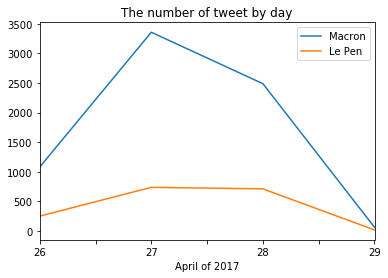

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
df_date.groupby('day').agg({'Macron' : 'sum', 'Le Pen': 'sum'}).plot()
plt.title("The number of tweet by day")
plt.xlabel("April of 2017")
plt.savefig("pic.png")